In [1]:
from helper_functions import *
from multi_armed_bandits_algorithms import *

# Multi-armed bandits

### Initialization of the variables

In [2]:
# Total number of arms
n_arms = 6

# Probabilities
true_probs = np.random.rand(n_arms)
highest_prob_arm = np.argmax(true_probs)

In [3]:
# Variables needed to calculate the money variation
initial_money = 5000
price_per_play = 0.5
reward = 1
loss = 0

## Theoretical success rate of each arm

In the bar chart below, we can see the probability of success for each arm, this probability of sucess has been generated randomly.

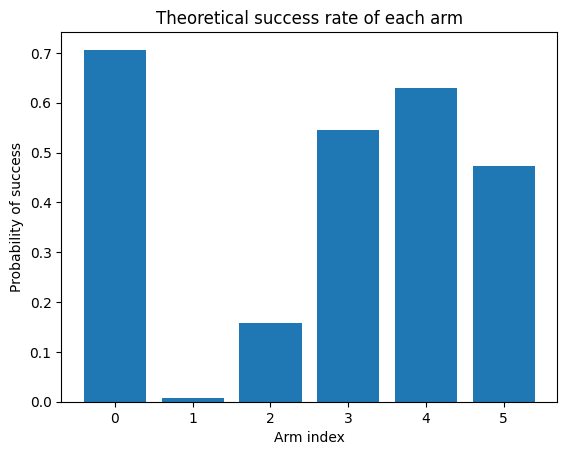

In [4]:
show_plot(bar_plot(x_values = range(len(true_probs)), y_values = true_probs, x_label="Arm index", y_label="Probability of success", title="Theoretical success rate of each arm"))

In [5]:
print("True probabilites for each arm : ")
print(true_probs)
print("")
print("The arm with the highest probability is at index : " + str(highest_prob_arm) + " \nits probability is : " + str(true_probs[highest_prob_arm]))

True probabilites for each arm : 
[0.70645804 0.00815169 0.15860007 0.54568417 0.62974955 0.47363734]

The arm with the highest probability is at index : 0 
its probability is : 0.7064580413723177


# Strategy 1 : Explore then exploit

For this, we explore by playing a 100 times each arm, then depending on which one got us the most wins, we decide to commit to it.

In [6]:
# Setting the number of steps
n_steps = 10000

# Running the algorithm
explore_per_arm, results_all_arms_end_of_explore, end_of_explore_results, actions, rewards, changes = explore_then_exploit_naive(n_steps, n_arms, explore_fraction=0.3, p=true_probs)

## Number of wins as the number of pulls for each arm increases

In the plot below, we can see the total number of wins as we pull the arm more and more. We can see that as the number of pulls increases, the difference in successes grows between the arms. Which is understandable since according to the law of large numbers, as the number of pulls increases we get a success rate that approaches the theoretical success rate of each arm.

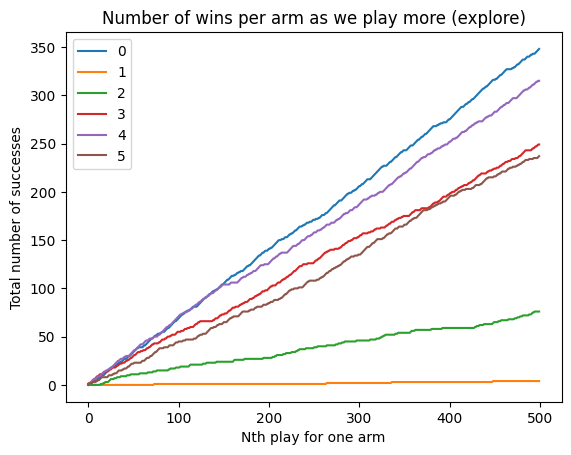

In [7]:
cum_sum_results_all_arms = np.cumsum(results_all_arms_end_of_explore, axis=1)
multiple_lines_plot(x_values=range(explore_per_arm), y_values_list=cum_sum_results_all_arms, labels=range(n_arms), x_label="Nth play for one arm", y_label="Total number of successes", title="Number of wins per arm as we play more (explore)")

## Results at the end of explore step

In the bar chart below, you can see which arm has won the most, we can also divide by the total number of plays to see the empirical probabilities of success.

In [8]:
print("at the end of the explore step, those are the total number of success for each arm :\n" + str(end_of_explore_results))

at the end of the explore step, those are the total number of success for each arm :
[348.   4.  76. 249. 315. 237.]


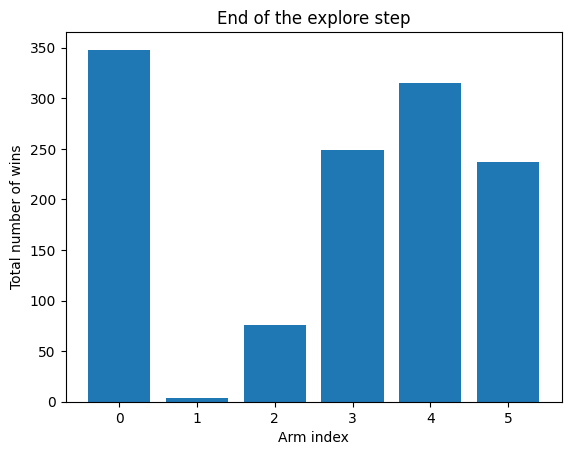

In [9]:
show_plot(bar_plot(x_values=range(len(end_of_explore_results)), y_values=end_of_explore_results, x_label="Arm index", y_label="Total number of wins", title="End of the explore step"))

In [10]:
index_with_most_wins = np.argmax(end_of_explore_results)
print("The arm that won the most at the end of exploration phase is : " + str(index_with_most_wins) + " with " + str(int(end_of_explore_results[index_with_most_wins])) + " wins.")

The arm that won the most at the end of exploration phase is : 0 with 348 wins.


### Comparison theoretical probabilities vs empirical probabilities

The horizontal red lines represent the true probability of success. We see that there are some gaps between the empirical (vertical bars in blue) and the theoretical values (horizontal lines in red).

If we increase the number of exploration steps for each arm, the gap between the empirical and theoretical values will decrease.

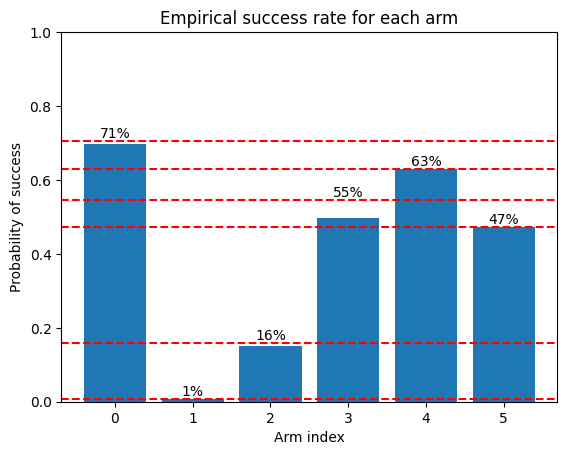

In [11]:
show_plot(bar_plot_explore_then_exploit(x_values=range(len(end_of_explore_results)), y_values=end_of_explore_results / results_all_arms_end_of_explore.shape[1] , x_label="Arm index", y_label="Probability of success", title="Empirical success rate for each arm", true_probs=true_probs))

## Money variation

In the plot below, we can see the variation in money as a function of time t (t representing the number of pulls).

Since we plotted vertical dashed lines in red that represents a switch in arm, we see that when we choose an arm with low success rate, the slope becomes low and sometimes even negative (we loose more money than we gain !!!).

When choosing an arm with high success rate, the slope is more positive (we win more money than we spend pulling the arm).

Overall, after the explore phase, when we decide to commit to the arm with highest empirical success rate, we see that the total money gain goes up.

Money initially : 5000
Money invested : 5000.0
Money gained : 6244.0
Money difference : 1244.0
Money left : 6244.0


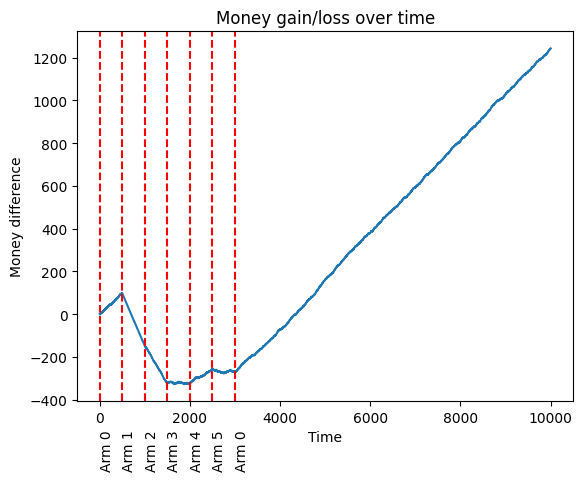

In [12]:
money_stats(initial_money, price_per_play, n_steps, reward, rewards)

show_plot(money_plot_explore_then_exploit(rewards, price_per_play, changes))

## Regret

In the plot below we see the regret, the slope is 0 when we pick the best arm (the one with highest probability of success).

The slope becomes greater when picking an arm with lower success rate.

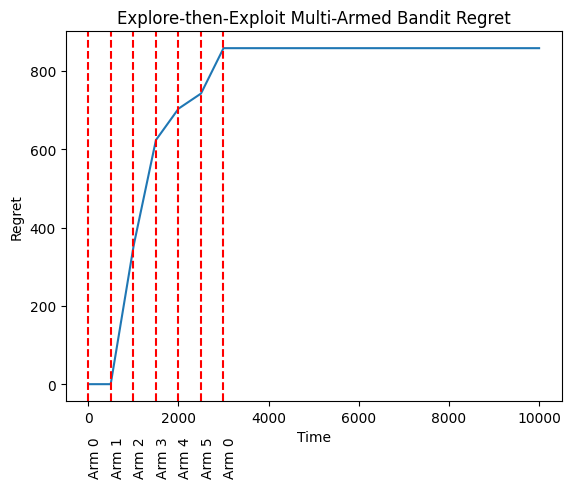

In [13]:
regret_vals = regret(actions, true_probs)
show_plot(regret_plot_explore_then_exploit(y_values=regret_vals, title="Explore-then-Exploit Multi-Armed Bandit Regret", changes=changes))

## Suboptimal arm chosen

In the plot below we see how the number of times we choose a suboptimal arm varies. At the end of the explore case, we pick (in most cases and if the exploration phase was large enough) the optimal arm and so the number total do not increase. 

This plot is somewhat similar to the regret plot in the way that the slope becomes 0 when playing the optimal arm.

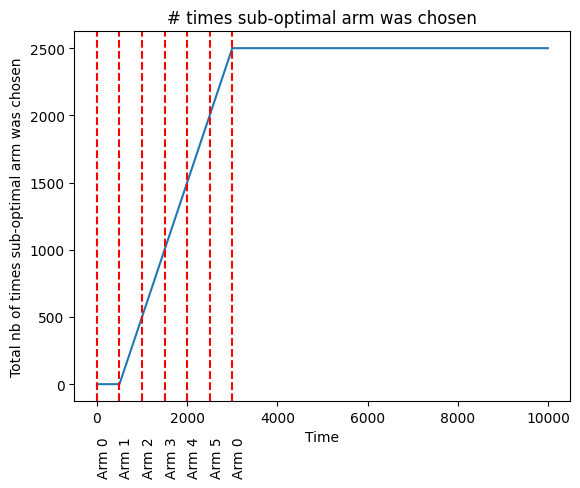

In [14]:
show_plot(add_vertical_lines(sub_optimal_arm_chosen_plot(p=true_probs, actions=actions), changes))

# Strategy 2 : Explore then exploit - by elimination

In the previous strategy, we say decide initially how much we are going to play. 

If we analyse the graph of exploring, we can see that after some plays, we can notice a significant difference in success rate for each arm.

Therefore, to avoid pulling an arm that performs very bad again and again, we can eliminate it the worst performing arm after a given number of plays so that we can avoid wasting any more money on that particular arm.

So the algorithm works as follow:

We decide on the number of rounds of eliminations we want, and the amount of time each arm has to be pulled. At the end of the round, we eliminate the worst performing arm and therefore wasting money on it.

In [25]:
# Setting the number of steps
n_trials = 5000

# Running the algorithm
results_all_arms_end_of_explore, end_of_explore_total, results_all_arms, eliminations, actions, rewards, changes = explore_then_exploit_elimination(n_trials, n_arms, n_arms - 1, 200, p=true_probs)

## Exploration phase

During the exploration phase, every round, we pull each arm for a given amount.

After pulling all arms, we look at which one has performed the worst up until now. We eliminate the lowest performing one to avoid pulling it again in the next rounds. We continue up until we finish all rounds.

At the end, we select the arm that has performed the best (the one who has the highest empirical success rate) and we spend the rest of our money on it.

### Number of wins as the number of pulls for each arm increases

In the plot below, we can see the total number of wins as we pull the arm more and more. We can see that as the number of pulls increases, the difference in successes grows between the arms.

However, we can see that at the end of each round, the lowest performing arm is eliminated. This is why the slope becomes equal to zero (the total number of successes stops increasing) since we stop pulling those arms.

In [26]:
i = 1
for arm_step in eliminations:
    print("Round " + str(i) + ", The arm that won the least is : " + str(arm_step[0]) + " with " + str(int(end_of_explore_total[arm_step[0]])) + " wins.")
    i = i + 1

Round 1, The arm that won the least is : 1 with 0 wins.
Round 2, The arm that won the least is : 2 with 72 wins.
Round 3, The arm that won the least is : 5 with 289 wins.
Round 4, The arm that won the least is : 3 with 449 wins.
Round 5, The arm that won the least is : 4 with 630 wins.


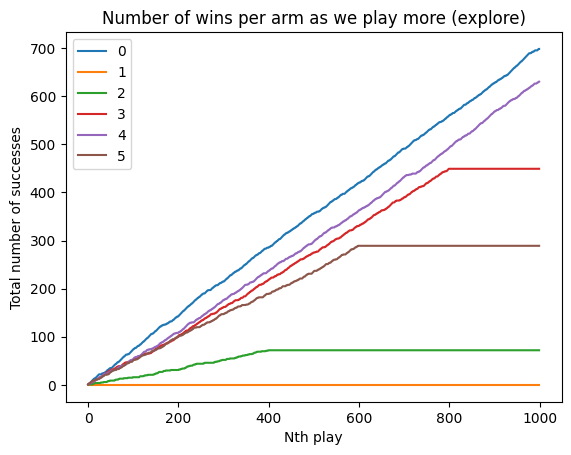

In [27]:
cum_sum_results_all_arms = np.cumsum(results_all_arms_end_of_explore, axis=1)

multiple_lines_plot(x_values=range(results_all_arms_end_of_explore.shape[1]), y_values_list=cum_sum_results_all_arms, labels=range(n_arms), x_label="Nth play", y_label="Total number of successes", title="Number of wins per arm as we play more (explore)")

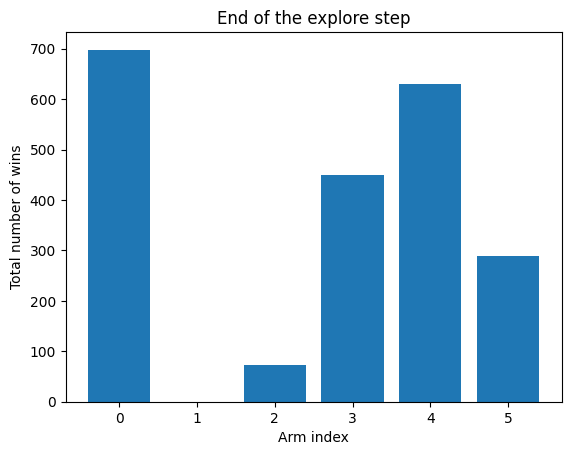

In [28]:
show_plot(bar_plot(x_values=range(len(end_of_explore_total)), y_values=end_of_explore_total, x_label="Arm index", y_label="Total number of wins", title="End of the explore step"))

In [29]:
index_with_most_wins = np.argmax(end_of_explore_total)
print("The arm that won the most at the end of exploration phase is : " + str(index_with_most_wins) + " with " + str(int(end_of_explore_total[index_with_most_wins])) + " wins.")

The arm that won the most at the end of exploration phase is : 0 with 698 wins.


### Comparison theoretical probabilities vs empirical probabilities¶

The horizontal red lines represent the true probability of success. 

We see that at the end of the exploration phase, we have a pretty good approximation for the probability of success for the best performing arms. This is because we pulled them more than the ones that got eliminated. 

There are some gaps between the empirical (vertical bars in blue) and the theoretical values (horizontal lines in red).

Empirical probabilities : 
[0.698      0.         0.18       0.56125    0.63       0.48166667]


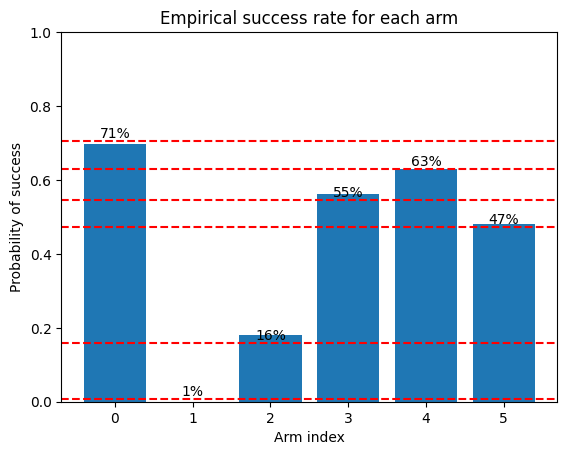

In [30]:
empirical_probabilities = empirical_probabilities_with_eliminations(results_all_arms_end_of_explore, end_of_explore_total, eliminations)

print("Empirical probabilities : ")
print(empirical_probabilities)

show_plot(bar_plot_explore_then_exploit(x_values=range(n_arms), y_values=empirical_probabilities , x_label="Arm index", y_label="Probability of success", title="Empirical success rate for each arm", true_probs=true_probs))

## Money variation
In the plot below, we can see the variation in money as a function of time t (t representing the number of pulls).

Since we plotted vertical dashed lines in red that represents a switch in arm, we see that when we choose an arm with low success rate, the slope becomes low and sometimes even negative (we loose more money than we gain !!!).

When choosing an arm with high success rate, the slope is more positive (we win more money than we spend pulling the arm).

Overall, after the explore phase, when we decide to commit to the arm with highest empirical success rate, we see that the total money gain goes up.

Money initially : 5000
Money invested : 5000.0
Money gained : 2850.0
Money difference : -2150.0
Money left : 2850.0


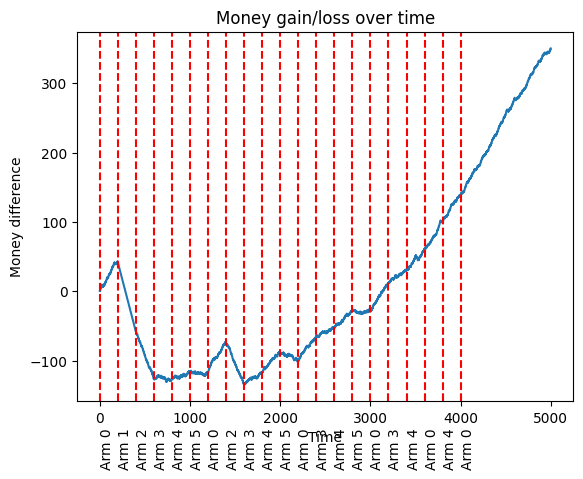

In [31]:
money_stats(initial_money, price_per_play, n_steps, reward, rewards)
show_plot(money_plot_explore_then_exploit(rewards, price_per_play, changes))

## Regret

In the plot below we see the regret, the slope is 0 when we pick the best arm (the one with highest probability of success).

The slope becomes greater when picking an arm with lower success rate.

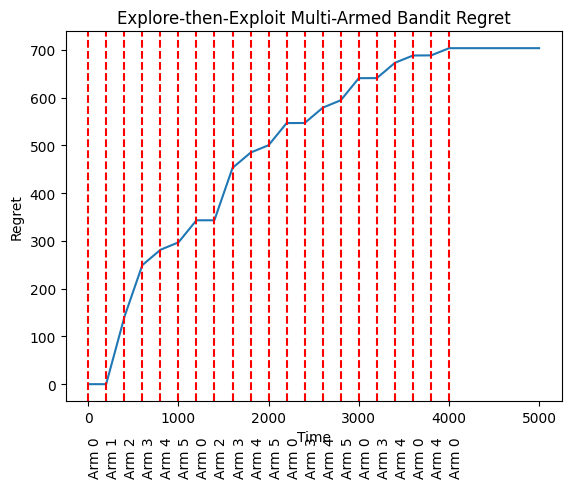

In [32]:
regret_vals = regret(actions, true_probs)
show_plot(regret_plot_explore_then_exploit(y_values=regret_vals, title="Explore-then-Exploit Multi-Armed Bandit Regret", changes=changes))

## Suboptimal arm chosen

In the plot below we see how the number of times we choose a suboptimal arm varies. At the end of the explore case, we pick (in most cases and if the exploration phase was large enough) the optimal arm and so the number total do not increase.

This plot is somewhat similar to the regret plot in the way that the slope becomes 0 when playing the optimal arm.

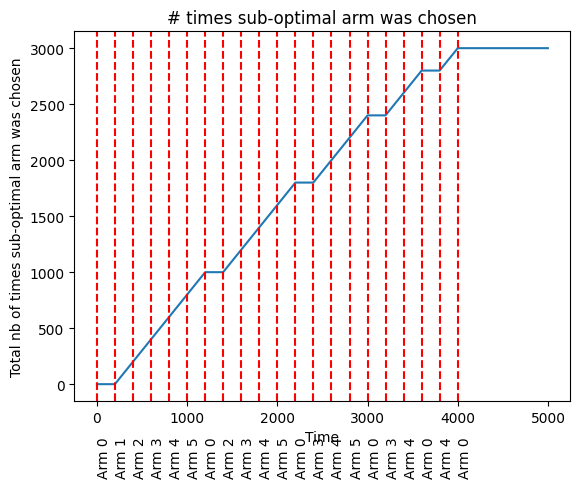

In [33]:
show_plot(add_vertical_lines(sub_optimal_arm_chosen_plot(p=true_probs, actions=actions), changes))

# Strategy 3 : Epsilon-Greedy Algorithm

In the previous strategy, we say decide initially how much we are going to play. This can become a problem in situations where we have limited resources. 
A strategy would be to assign weights to each arm and recalculate every time we try one.

The epsilon-greedy algorithm is a simple algorithm for exploring and exploiting a set of options or actions in a reinforcement learning problem or a multi-armed bandit problem. The algorithm works as follows:

1. Initialize a set of action-value estimates Q(a) for each action a.

2. For each time step t:

    a. With probability epsilon, select a random action.

    b. Otherwise, select the action with the highest action-value estimate.

    c. Take the selected action and observe the reward r.

    d. Update the action-value estimate Q(a) for the selected action using the observed reward r.

3. Repeat step 2 for a fixed number of time steps or until convergence.

In [140]:
# Initializing variables
n_trials = 5000
initial_money = 5000

# Check we have enough money
if n_trials * price_per_play > initial_money:
    raise Exception("You don't have enough money initially !")

In [141]:
# Running the algorithm
actions, rewards, N, Q = epsilon_greedy(n_trials, n_arms, epsilon=0.01, p=true_probs)

## Results at the end of epsilon-greedy
In the bar chart below, you can see which arm has won the most, we can also divide by the total number of plays to see the empirical probabilities of success.

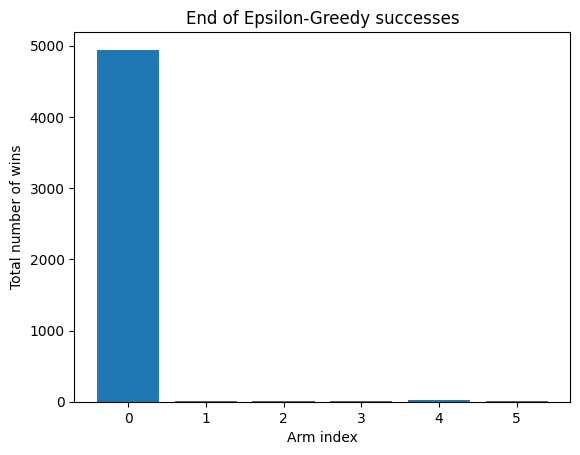

In [142]:
show_plot(bar_plot(x_values=range(len(N)), y_values=N, x_label="Arm index", y_label="Total number of wins", title="End of Epsilon-Greedy successes"))

In [143]:
print("Total successes for each arm at the end of epsilon-greedy : ")
print(N)

Total successes for each arm at the end of epsilon-greedy : 
[4944.    5.    9.   12.   21.    9.]


## Comparison theoretical probabilities vs empirical probabilities¶

The horizontal red lines represent the true probability of success.

We see that we have a pretty good approximation for the probability of success for the best performing arms. This is because we pulled them more often than the ones that got eliminated.

This is because, as we pull the arms, we get a better approximations for the success rates for the arms. That means that with a probability 1-epsilon, we will draw the one that has the highest success rate among all other arms. 

This is why the higher success rate arms have better approximation (the gap between the empirical values - vertical blue bars - and the theoretical values - horizontal red lines - is smaller than the gap for low success rate arms). This is because since they win less, we are less likely to pull them again and hence get a better approximation.

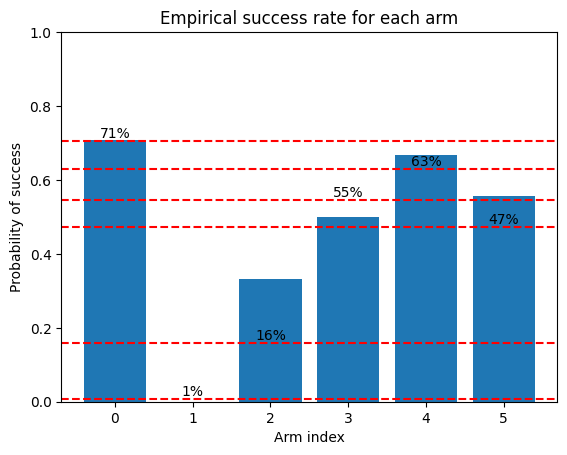

In [144]:
show_plot(bar_plot_explore_then_exploit(x_values=range(n_arms), y_values=Q , x_label="Arm index", y_label="Probability of success", title="Empirical success rate for each arm", true_probs=true_probs))

## Money variation

In the plot below, we can see the variation in money as a function of time t (t representing the number of pulls).

When choosing an arm with high success rate, the slope is more positive (we win more money than we spend pulling the arm).

At the start, since arms are pulled randomly until we get data, the slope might become negative.

The epsilon is a tradeoff. A big one means that will find out the best arm faster than if epsilon is smaller. However, in the long run, we will keep picking an arm at random with probability epsilon even after a very long amount of pulls, which makes it inefficient.

With a smaller epsilon, we might lose money in the beginning, eg: picks as the first arm randomly one with probability of success 1%, if it wins, we will pull this one again and again each time with probability 1-epsilon. Until another arm with higher success rate wins at least more than that one.

This might lead to losing money in the beginning but will bring highest return if the number of pulls increases.

Money initially : 5000
Money invested : 2500.0
Money gained : 3535.0
Money difference : 1035.0
Money left : 6035.0


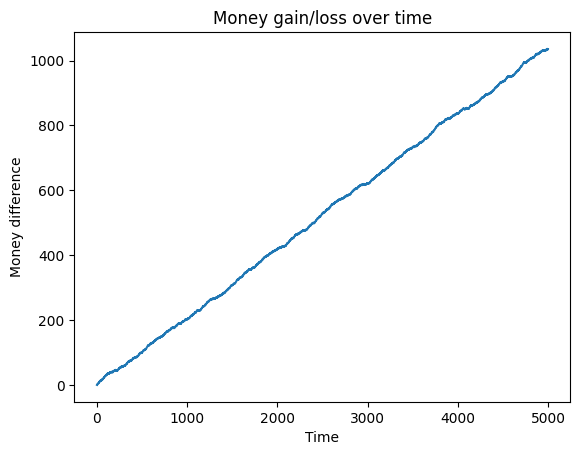

In [145]:
# Calculating money    
money_stats(initial_money, price_per_play, n_trials, reward, rewards)
show_plot(money_plot(rewards, price_per_play))


## Regret

In the plot below we see the regret, the slope is 0 when we pick the best arm (the one with highest probability of success).

There are 2 main parts in the plot :

a) The beginnning, in this phase, we are picking one arm at random, and we will need to wait until the best arm has succeeded more than all other arms. This phase might take longer depending on the value of epsilon.

A smaller value of epsilon will lead to a longer first phase of "trials/exploration", while a bigger value of epsilon will lead to a shorter "trial/exploration phase".

b) After the first phase, we normally have good estimates for each success rate of the arms, especially those who have a higher probability of success. Therefore, we will pick more often the best arm. And occasionally we pick one at random with probability epsilon.

This is the reason why we have a plot that resembles a logarithmic function and we don't have a flat line for the second part, unlike the explore-then-exploit algorithms.

In [150]:
# Compute the regret
regret_vals = regret(actions, true_probs)

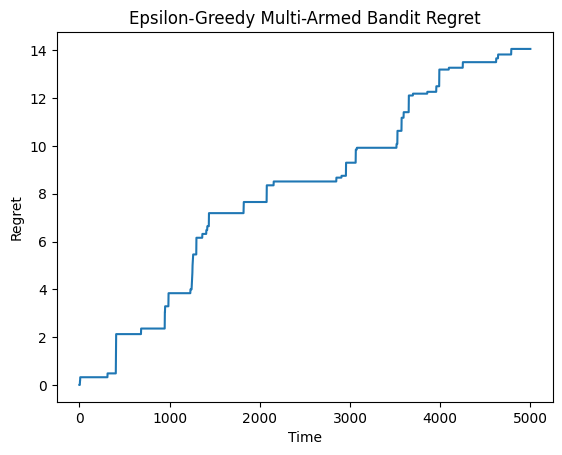

In [151]:
# Plot the regret
show_plot(line_plot(y_values=regret_vals, x_label="Time", y_label="Regret", title="Epsilon-Greedy Multi-Armed Bandit Regret"))

## Suboptimal arm chosen

In the plot below we see how the number of times we choose a suboptimal arm varies. 

The reasoning is the same as with the regret plot, there are mainly 2 phases, the exploration part and the exploit part.

When the number of success for the best arm has finally exceeded those of the other arms, we can see that the optimal arm is chosen every time with probability 1-epsilon.

It is not a flat line because epsilon-greedy is designed in such a way that an arm is always picked randomly with probability epsilon.

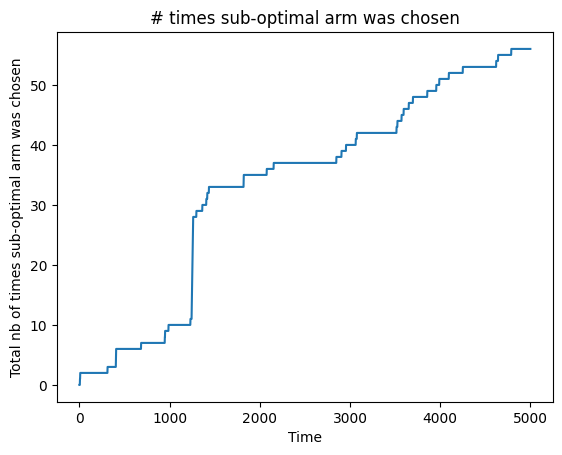

In [152]:
show_plot(sub_optimal_arm_chosen_plot(p=true_probs, actions=actions))

# Strategy 4 : Upper Confidence Bound variation with eliminations

We saw in the explore-then-commit variation, the 2nd strategy that we can eliminate the lowest performing arm at the end of each round. This was indeed better than the 1st strategy since we stop allocating resources to the low performing arm after a round, however, the number of pulls is fixed from the beginning and only one arm can be eliminated per round.

With this new strategy, we find a way to eliminate the arms with the condition that its upperbound estimate for the success rate is lower than the lowerbound estimate of the best arm. 

This way, we can eliminate the lower performing arms at a faster rate which saves us from spending resources on them.


### This strategy works as follows :

1) We initialize upper and lower bounds for each arm

2) We play each arm once and update the upper and lower bounds

3) We also check for each arm if it's upper bound is lower than the lower bound of the best arm. In this case, we eliminate this arm to prevent from playing it again.

4) Go to step 2, until we finish all trials

In [173]:
c = 0.9 # 0.8 is good
n_trials = 5000
initial_money = 5000

if n_trials * price_per_play > initial_money:
    raise Exception("Not enough money to play ! Decrease the number of trials")

In [174]:
# Running the algorithm
selected_arms, rewards, wins, losses, eliminations = elimination_confidence_bound_algorithm(n_arms, n_trials, c, true_probs)

## Eliminations

Below, you can see at which round which arm has been eliminated, and also at which trials it has been eliminated.

(A round is when we pulled all non-eliminated arms once)



In [175]:
for arm_round_step in eliminations:
    print("eliminated arm : " + str(arm_round_step[0]) + ", at round : " + str(arm_round_step[1] + 1) + ", at trial nb : " + str(arm_round_step[2]))

eliminated arm : 2, at round : 5, at trial nb : 30
eliminated arm : 1, at round : 8, at trial nb : 45
eliminated arm : 5, at round : 33, at trial nb : 145
eliminated arm : 3, at round : 60, at trial nb : 226
eliminated arm : 4, at round : 273, at trial nb : 652


## Estimate Intervals

In the chat below, we can see the probability estimates for each arm. The lower and upper bounds both represented with the red lines.

We can see that the interval for the best performing arms are shorter than those with lower success rates. This is due to the fact that they need to be pulled more and more until their upper bound becomes lower than the lower bound of the best one.

The interval for the best arm is the shortest since in the case where all other arms are eliminated, the best arm will always be pulled which leads to a better approximation for the probability of success.

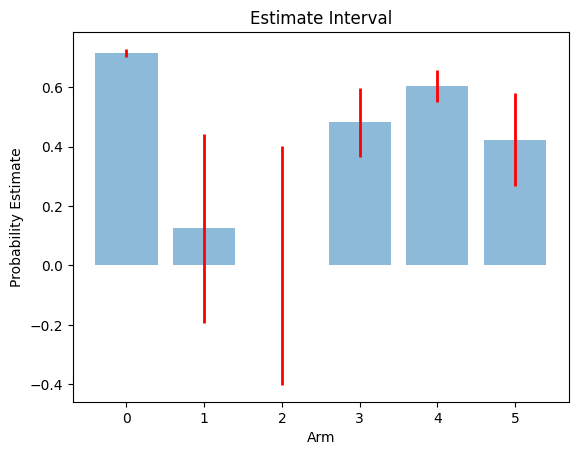

In [176]:
# Estimate interval at the end
plot_estimate_interval(n_arms, wins, losses, c)

## Regret

In the plot below we see the regret, the slope is 0 when we pick the best arm (the one with highest probability of success).

There are 2 main parts in the plot :

a) The beginnning, we are pulling all arms once before checking for elimination possibilities. This phase might take longer depending on the value of c.

A bigger value of c will lead to a longer first phase of "trials/exploration with eliminations", while a smaller value of c will lead to a shorter "trial/exploration with eliminations phase".

b) After the first phase, we normally have eliminated all lowest performing arms, therefore we will pick the best arm. This is why the slope becomes equal to 0 later because all other arms except the best one have been eliminated. 


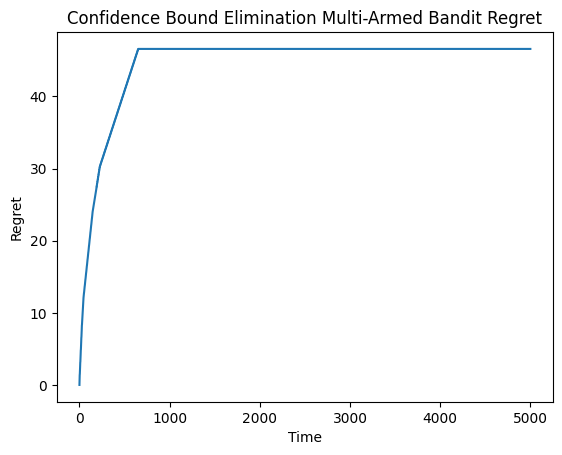

In [177]:
# Compute the regret
regret_vals = regret(selected_arms, true_probs)

# Plot the regret
show_plot(line_plot(y_values=regret_vals, x_label="Time", y_label="Regret", title="Confidence Bound Elimination Multi-Armed Bandit Regret"))

## Suboptimal arm chosen

Same reasoning as the regret plot.

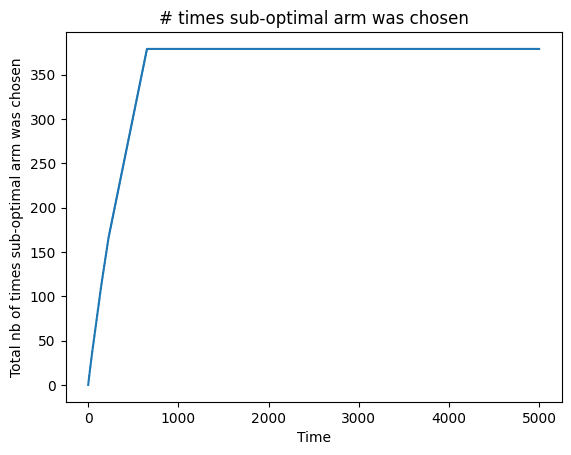

In [178]:
show_plot(sub_optimal_arm_chosen_plot(p=true_probs, actions=selected_arms))

## Money variation

In the plot below, we can see the variation in money as a function of time t (t representing the number of pulls).

When choosing an arm with high success rate, the slope is more positive (we win more money than we spend pulling the arm).

Since this algorithm can eliminate arms at a faster rate than the explore-then-exploit strategy 2 we implemented previously, we start winning money rapidly/sooner.

Money initially : 5000
Money invested : 2500.0
Money gained : 3520.0
Money difference : 1020.0
Money left : 6020.0


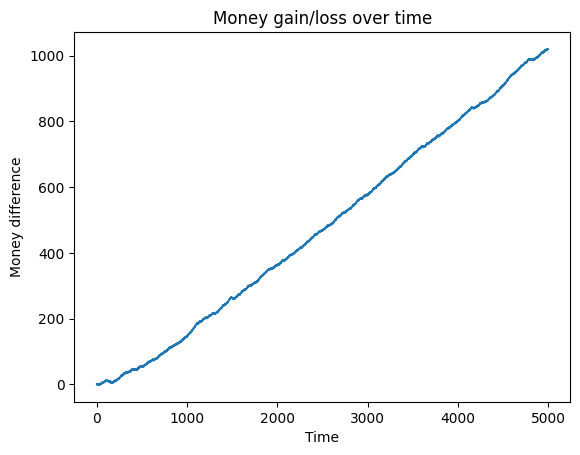

In [179]:
money_stats(initial_money, price_per_play, n_trials, reward, rewards)

show_plot(money_plot(rewards, price_per_play))

# Strategy 5 : Upper Confidence Bound

We saw in the explore-then-commit variation, the 2nd strategy that we can eliminate the lowest performing arm at the end of each round. This was indeed better than the 1st strategy since we stop allocating resources to the low performing arm after a round, however, the number of pulls is fixed from the beginning and only one arm can be eliminated per round.

With this new strategy, we find a way to eliminate the arms with the condition that its upperbound estimate for the success rate is lower than the lowerbound estimate of the best arm. 

This way, we can eliminate the lower performing arms at a faster rate which saves us from spending resources on them.


### This strategy works as follows :

1) We initialize upper and lower bounds for each arm

2) We calculate the upper and lower bounds for each arm

3) We play the arm with the highest upperbound and store the result of the pull.

4) Go to step 2, until we finish all trials.

In [180]:
# variables
c = 0.9 # 0.8 is good
n_trials = 5000
initial_money = 5000

if n_trials * price_per_play > initial_money:
    raise Exception("Not enough money to play ! Decrease the number of trials")

In [181]:
# Running the algorithm
selected_arms, rewards, wins, losses = ucb_algorithm(n_arms, n_trials, c, true_probs)

## Estimate Intervals
In the chat below, we can see the probability estimates for each arm. The lower and upper bounds both represented with the red lines.

We can see that the interval for the best performing arms are shorter than those with lower success rates. This is due to the fact that they need to be pulled more and more until their upper bound becomes lower than the lower bound of the best one.

The interval for the best arm is the shortest since the best arm will be pulled most often which leads to a better approximation for the probability of success.

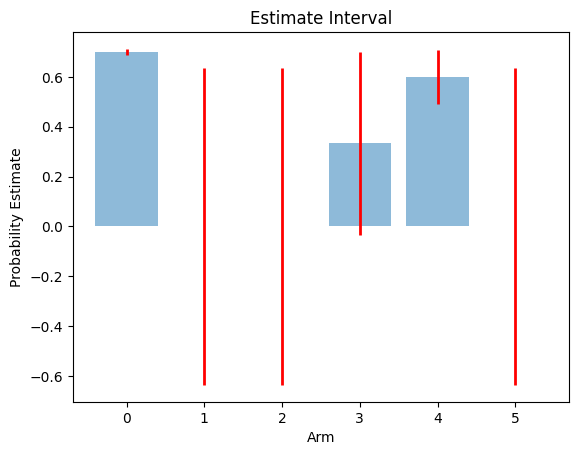

In [182]:
# estimate interval at the end 
plot_estimate_interval(n_arms, wins, losses, c)

## Regret

We can see the regret in the plot below. There are 2 main phases, one where we pull the arms eliminating them "indirectly". In the beginning all arms have the same high upperbounds, but as the number of pull increases, those estimates will become more and more accurate and we will only keep pulling the arm with the highest probability of success.

We can sometimes see multiple "corners/edges" just before the angle. This is most likely due to the fact of having two best performing arms that are close to each other in probabilities. So when one is chosen, the other one is chosen after another few rounds and so on, until one is clearly better than the other.

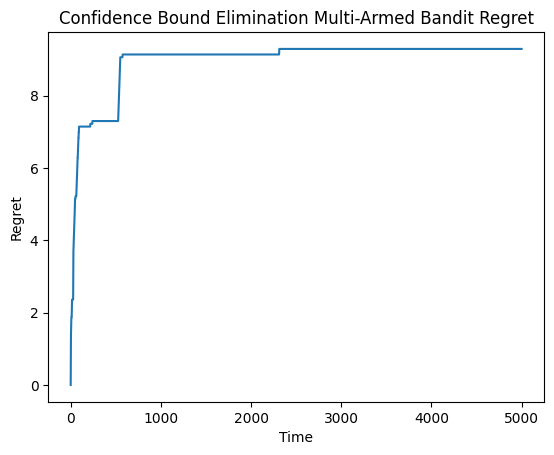

In [183]:
# Compute the regret
regret_vals = regret(selected_arms, true_probs)

# Plot the regret
show_plot(line_plot(y_values=regret_vals, x_label="Time", y_label="Regret", title="Confidence Bound Elimination Multi-Armed Bandit Regret"))

## Suboptimal arm chosen

Same reasoning as the regret plot. 

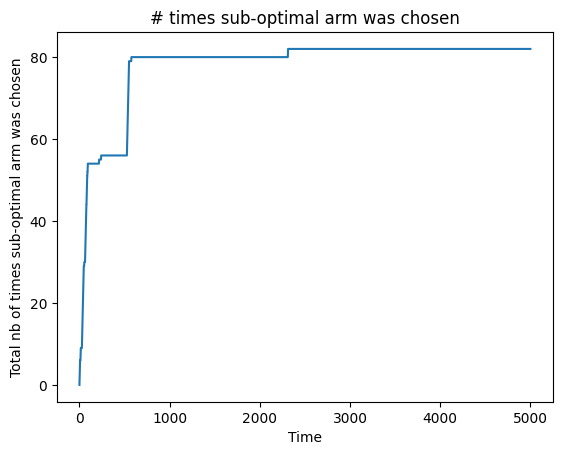

In [184]:
show_plot(sub_optimal_arm_chosen_plot(p=true_probs, actions=selected_arms))

## Money variation

In the plot below, we can see the variation in money as a function of time t (t representing the number of pulls).

The money variation is in direct correlation with the regret plot.

As soon as we start picking up the best arm, the money gain increases.

Money initially : 5000
Money invested : 2500.0
Money gained : 3484.0
Money difference : 984.0
Money left : 5984.0


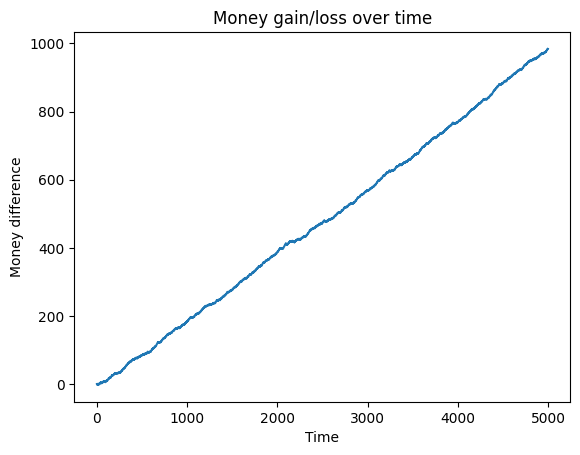

In [185]:
money_stats(initial_money, price_per_play, n_trials, reward, rewards)

show_plot(money_plot(rewards, price_per_play))